In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('../../data/data.csv')
print(df.columns)
print(df.info())

X = df.drop(columns=["PlayerID", "EngagementLevel"])
y= df["EngagementLevel"]
X = pd.get_dummies(X, columns=['Gender', 'Location', 'GameGenre', 'GameDifficulty'], drop_first=True)

Index(['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours',
       'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'EngagementLevel'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSe

In [4]:
features_kmeans = [
    'Age',
    'PlayTimeHours',
    'SessionsPerWeek',
    'AvgSessionDurationMinutes',
    'InGamePurchases'
]

X_km = df[features_kmeans]


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_km)


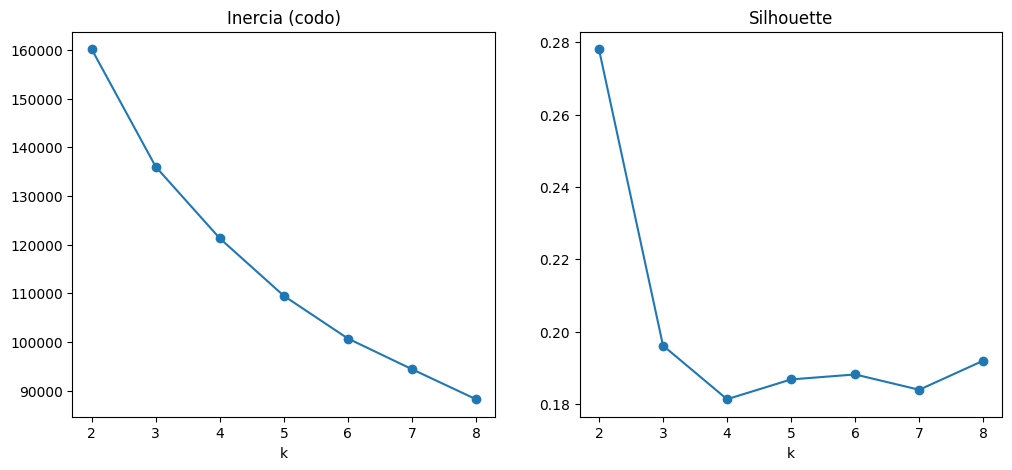

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



Ks = range(2, 9)
sil_scores = []
inertias = []

for k in Ks:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=50,
        random_state=42
    )
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(Ks, inertias, 'o-')
plt.title('Inercia (codo)')
plt.xlabel('k')

plt.subplot(1,2,2)
plt.plot(Ks, sil_scores, 'o-')
plt.title('Silhouette')
plt.xlabel('k')

plt.show()

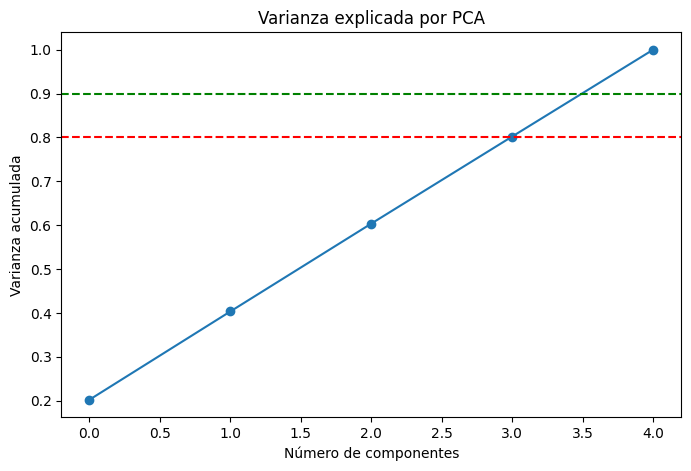

In [ ]:

pca_full = PCA()
pca_full.fit(X_scaled)

explained_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(explained_var, 'o-')
plt.axhline(0.8, color='r', linestyle='--')
plt.axhline(0.9, color='g', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza explicada por PCA')
plt.show()


Varianza explicada: [0.2024 0.2012 0.2002]
Varianza acumulada: 0.6037
Silhouette: 0.2432


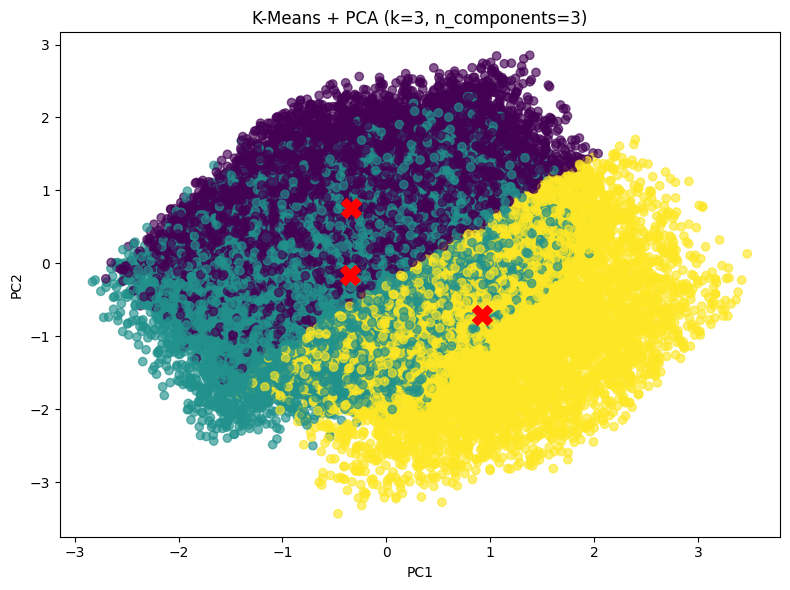

     Age  PlayTimeHours  SessionsPerWeek  AvgSessionDurationMinutes  \
0  33.64          16.84             7.86                      62.86   
1  31.45          11.06             9.51                     138.90   
2  30.71           7.39            11.43                      72.26   

   InGamePurchases  
0             0.09  
1             0.04  
2             0.57  
EngagementLevel   High    Low  Medium
Cluster_PCA                          
0                0.075  0.412   0.512
1                0.450  0.142   0.408
2                0.215  0.229   0.556


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df[features_kmeans].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada:", np.round(pca.explained_variance_ratio_, 4))
print("Varianza acumulada:", round(pca.explained_variance_ratio_.sum(), 4))

kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=100,
    max_iter=500,
    random_state=42
)

clusters = kmeans.fit_predict(X_pca)
df['Cluster_PCA'] = clusters

sil = silhouette_score(X_pca, clusters)
print("Silhouette:", round(sil, 4))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.65)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c='red',
    marker='X',
    s=200
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means + PCA (k=3, n_components=3)')
plt.tight_layout()
plt.show()

centroids_scaled = pca.inverse_transform(kmeans.cluster_centers_)
centroids_original = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids_original, columns=features_kmeans)
print(centroids_df.round(2))

if 'EngagementLevel' in df.columns:
    print(pd.crosstab(df['Cluster_PCA'], df['EngagementLevel'], normalize='index').round(3))


In [9]:
df.groupby('Cluster_PCA')[features_kmeans].mean().round(2)
pd.crosstab(df['Cluster_PCA'], df['EngagementLevel'], normalize='index')


EngagementLevel,High,Low,Medium
Cluster_PCA,,,
0,0.075371,0.412447,0.512183
1,0.450308,0.141988,0.407705
2,0.214722,0.229043,0.556235


## Justificación de la Variable de Clustering

La incorporación de una variable de cluster como nueva característica puede ser una buena estrategia para capturar patrones de comportamiento que no son evidentes a partir de las variables originales de forma individual.

A partir del análisis realizado con K-Means sobre las variables numéricas, se observa que los jugadores pueden agruparse en perfiles diferenciados según su comportamiento de juego (tiempo total, frecuencia de sesiones y duración media). Estos clusters representan combinaciones de comportamiento que no quedan reflejadas en una única variable aislada.

Al añadir el identificador de cluster al modelo de clasificación, se proporciona información agregada sobre el perfil global del jugador, lo que permite al modelo:
- Diferenciar jugadores con valores similares en una variable pero comportamientos globales distintos
- Simplificar relaciones no lineales entre variables originales
- Mejorar la capacidad predictiva en algunos modelos al introducir una señal de alto nivel

Los resultados muestran que, en determinados modelos, la inclusión de esta variable contribuye a una mejor separación entre clases de engagement, lo que justifica su uso como característica adicional en el proceso de modelado.
